In [1]:
import torch.optim as optim
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from models import CNN
from pathlib import Path
from MLDataTools.image_normalization import RandomDihedral
from skimage.external import tifffile as tiff
import numpy as np
from tensorboardX import SummaryWriter
from matplotlib import pyplot

%matplotlib inline

# torch setup
torch.set_default_tensor_type(torch.DoubleTensor) # so it doesnt throw a incompatible type exception
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # important for cloud compatability

## TensorBoard to visualise class embeddings


In [2]:
# tensorboard setup
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d.%H:%M:%S")

writer = SummaryWriter('tensorboardx/SimpleCNN_'+date)

## Initialize the train loader and the test loader

In [3]:
DATA_ROOT = '/Users/cerber/HDev Dropbox/Projects/YNet_ready_data/yeast_v4'
data_path = Path(DATA_ROOT)

In [4]:
def tiff_read(path:str):
    image = tiff.imread(path).astype(np.double)
    return image

class GetInfo:
    def __init__(self, label=None):
        self.label = label
    def __call__(self, sample):
        try:
            print(sample.shape)
        except: pass
        finally:
            if self.label: print(self.label)
            print(type(sample))
            return sample


In [5]:
ds_transforms = transforms.Compose([
    RandomDihedral()
])
BATCH_SIZE = 40
trainset = torchvision.datasets.ImageFolder(DATA_ROOT+'/train', transform=ds_transforms, loader=tiff_read)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(DATA_ROOT+'/test', transform=ds_transforms, loader=tiff_read)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [6]:
# class_name: (mean, stdev)
stats = {
    'WT': ([48.37304926, 95.64728183],
  [521.95544101, 310.77445807]),
    'mfb1KO': ([ 47.58621839, 102.40188124],
  [520.43241635, 311.95406937]),
    'mfb1KO_mmr1KO': ([ 47.79873863, 100.28439551],
  [517.82433373, 310.53787264]),
    'mmr1KO': ([ 49.22677943, 110.97112597],
  [522.00261751, 315.86275802])
}

# invert class_to_id
idx_to_class = {v:k for k,v in trainset.class_to_idx.items()}
norm_transforms = {} # class_id: normalization_transformation for that class
for key, value in stats.items():
    label = trainset.class_to_idx[key]
    norm_transforms[label] = transforms.Normalize(value[0],value[1])

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(32 * 47 * 47, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 32 * 47 * 47)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)


net = Net().double()


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [9]:
def train(epoch):
    net.train() # affects only modules like Dropout
    trainiter = iter(trainloader)
    for batch_idx, (data, targets) in enumerate(trainiter, 0):
        # get the inputs
        for i, target in enumerate(targets, 0): # normalize the inputs according to class
            t = norm_transforms[target.item()]
            data[i] = t(data[i])

        data, targets = data.to(device), targets.to(device)
        
        # backprop
        optimizer.zero_grad() # dont forget to do that
        output = net(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        # tensorboard
        global global_step
        global_step += 1
        writer.add_scalar('Train_Loss', loss.item(), global_step)
        if batch_idx % 2 == 0: # every 2nd batch add to our embedding writer
            targets = targets.type(torch.DoubleTensor)
            data = torch.cat((data.data,torch.zeros(40, 1, 200,200)), dim=1)
            writer.add_embedding(output, metadata=targets.data, label_img=data.data, global_step=global_step)
        if batch_idx % 5 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} "
                  f"({100. * batch_idx / len(trainloader)}%)]\tLoss: {loss.item()}")
        

In [10]:
def test(epoch):
    with torch.no_grad():
        net.eval()
        test_loss = 0
        wcases = [] # list of worst cases
        classes_correct = list(0 for i in range(NUM_CLASSES))
        classes_total = list(0 for i in range(NUM_CLASSES))
        
        for data, targets in iter(testloader):
            data, targets = data.to(device), targets.to(device)
            
            for i, target in enumerate(targets, 0): # normalize the inputs according to class
                t = norm_transforms[target.item()]
                data[i] = t(data[i])
            output = net(data)
            # errors is a top 2 List[error:float, index of sample:int]
            errors = worst_cases(output, targets)  
            
            for error, idx in errors:
                target = targets[idx].item()
                label = f"{idx_to_class[target]}_{error:3.2}"
                tensor = data[idx].numpy().copy()
                wcases.append((tensor,label))
            
            # sum up batch loss
            test_loss += criterion(output, targets).item()
            
            
            # get the index of the max log-probability
            _, pred = output.max(1) # returns a tuple the last element is the index Tensor
            c = (pred == targets).squeeze()
            l = c.size(0) # to account for different batch sizes
            # this helps to identify which classes the network is struggling with
            for i in range(l):
                label = targets[i].item()
                classes_correct[label] += c[i].item()
                classes_total[label] += 1
                        
        writer.add_scalar('Test_Loss', test_loss, epoch)
        test_loss /= len(testloader.dataset)
        accuracy = 100. * (sum(classes_correct) / sum(classes_total))
        print(f"\nTest set: Average loss: {test_loss:6.5}, Accuracy: {accuracy:5.2}\n")
        
        for i, total, correct in zip(range(NUM_CLASSES), classes_total, classes_correct):
            cl = idx_to_class[i]
            cl_accuracy = 100. * (classes_correct[i] / classes_total[i])
            print(f"class [{cl}]: accuracy {cl_accuracy:5.3}%")
        print()# prints a newline
        for image, label in wcases[:5]: # List[image:np.array, class:str]
            # should be of dimensions (2, 200, 200)
            tiff.imshow(image, title=label)

In [11]:
# helps to identify which cases the network was really wrong about
def worst_cases(output: torch.Tensor, targets: torch.Tensor, top=2):
    assert output.size(0) == targets.size(0)
    length = output.size(0)
    errors = []
    for i in range(length):
        z = torch.zeros(NUM_CLASSES)
        label = targets[i].item()
        z[label] = 1
        diff = (output[i] - z).numpy().copy()
        diff = np.sum(np.abs(diff))
        errors.append((diff, i))
        
    errors.sort(key=lambda x: x[0], reverse=True)
        
    return errors[:top]

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/609 (0.0%)]	Loss: 1.3665308197811905
Train Epoch: 0 [200/609 (31.25%)]	Loss: 1.427285354945919
Train Epoch: 0 [400/609 (62.5%)]	Loss: 1.3624043421709546
Train Epoch: 0 [135/609 (93.75%)]	Loss: 1.3369607206498608

Test set: Average loss: 0.040355, Accuracy: 2.3e+01

class [WT]: accuracy   0.0%
class [mfb1KO]: accuracy   0.0%
class [mfb1KO_mmr1KO]: accuracy   0.0%
class [mmr1KO]: accuracy 1e+02%

Train Epoch: 1 [0/609 (0.0%)]	Loss: 1.3213473041029924
Train Epoch: 1 [200/609 (31.25%)]	Loss: 1.3686383007133567
Train Epoch: 1 [400/609 (62.5%)]	Loss: 1.3504540861486567
Train Epoch: 1 [135/609 (93.75%)]	Loss: 1.3801984420536626

Test set: Average loss: 0.039388, Accuracy: 2.3e+01

class [WT]: accuracy   0.0%
class [mfb1KO]: accuracy   0.0%
class [mfb1KO_mmr1KO]: accuracy   0.0%
class [mmr1KO]: accuracy 1e+02%

Train Epoch: 2 [0/609 (0.0%)]	Loss: 1.3326512264274437
Train Epoch: 2 [200/609 (31.25%)]	Loss: 1.3679653651498516
Train Epoch: 2 [400/609 (62.5%)]	Loss: 1.378457517764

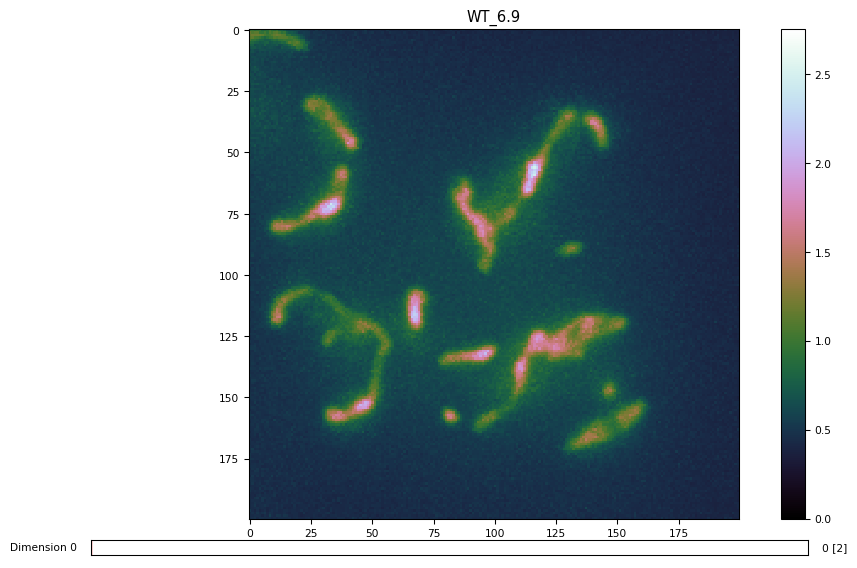

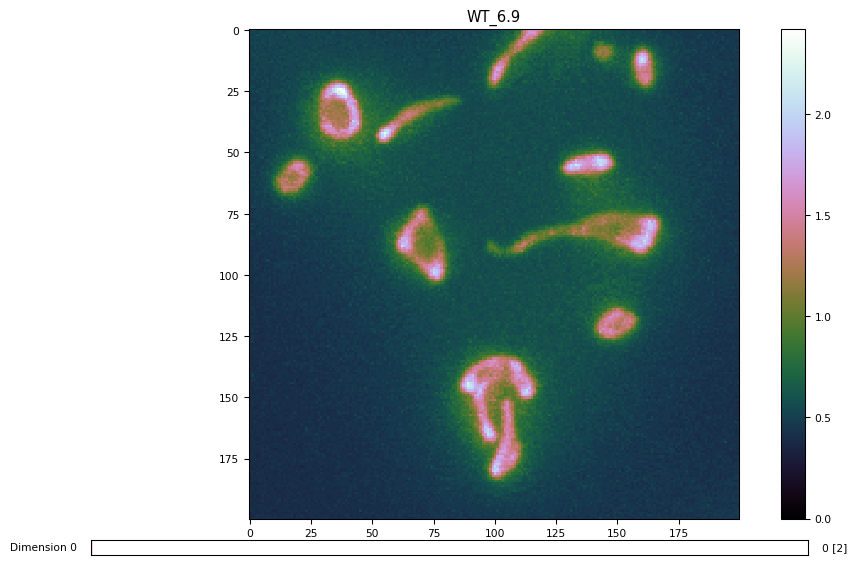

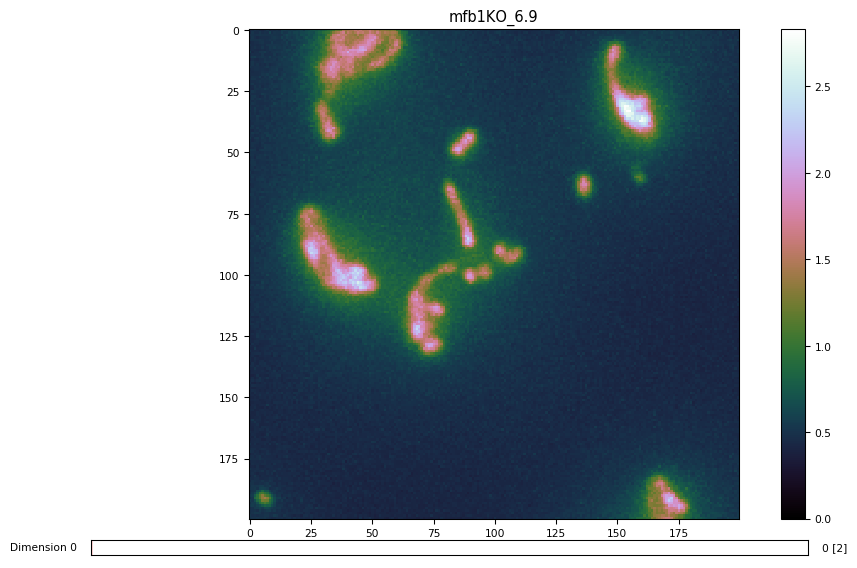

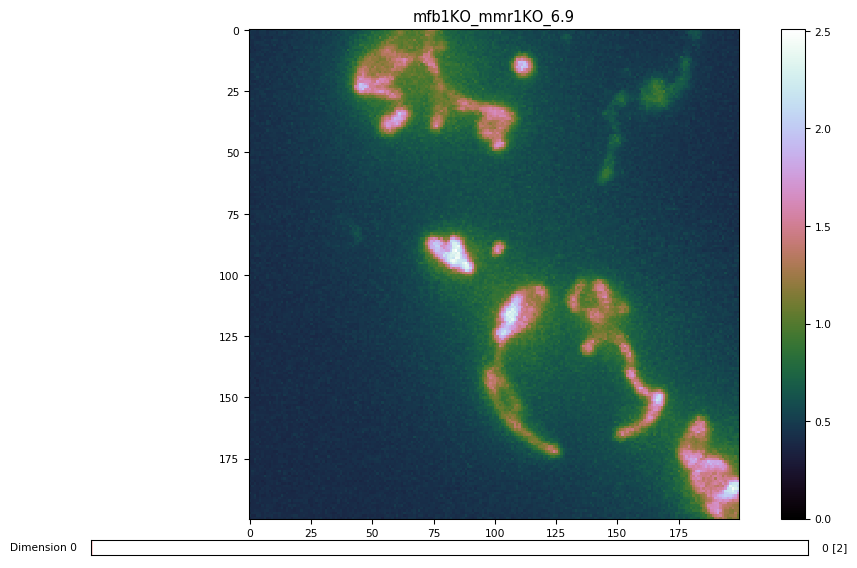

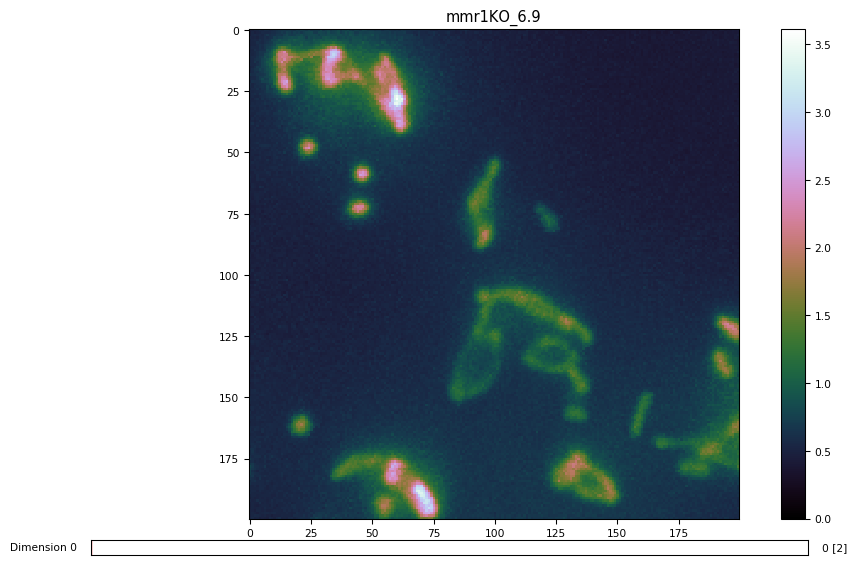

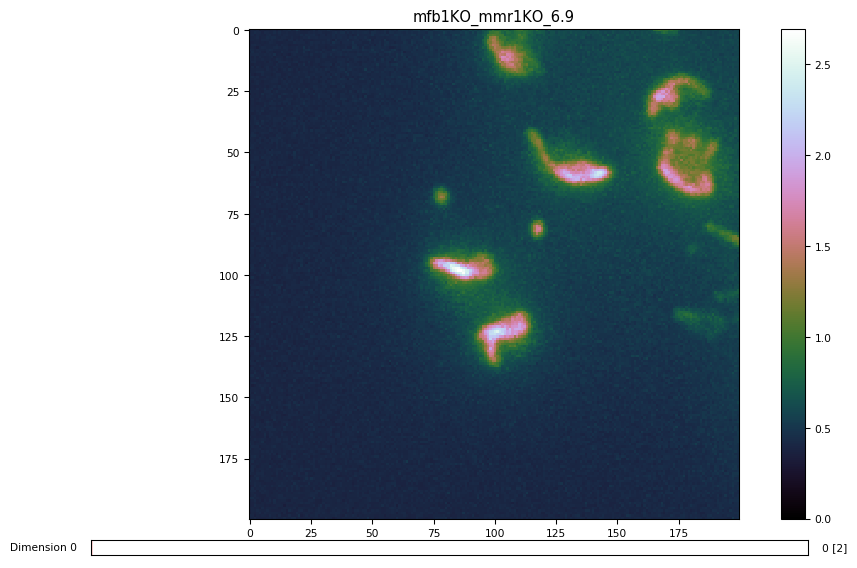

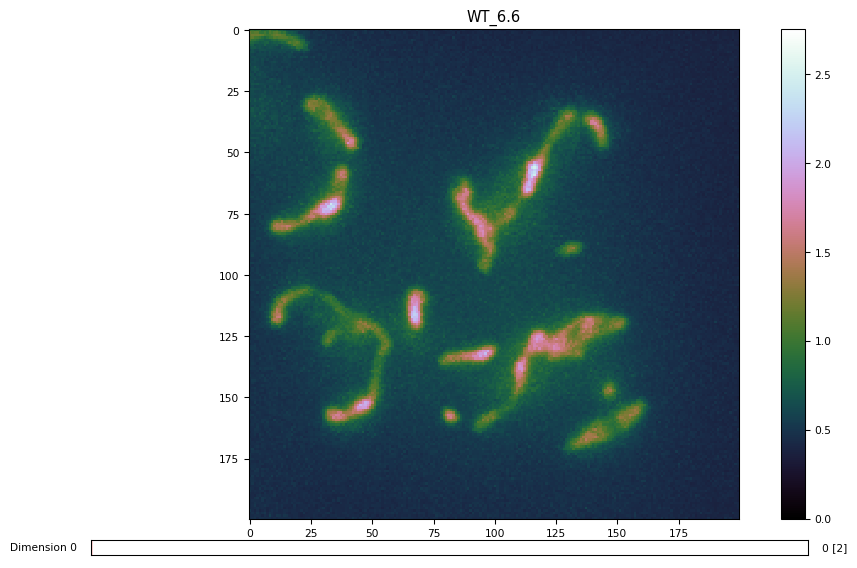

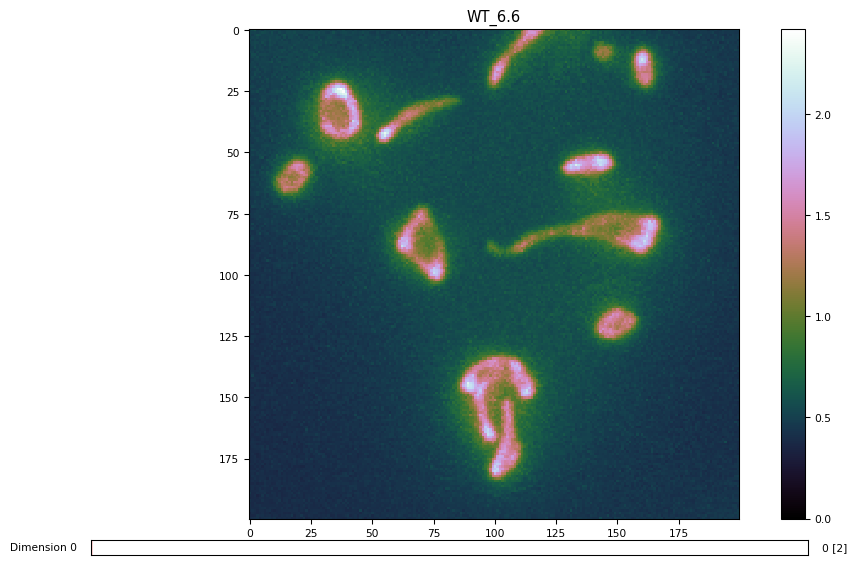

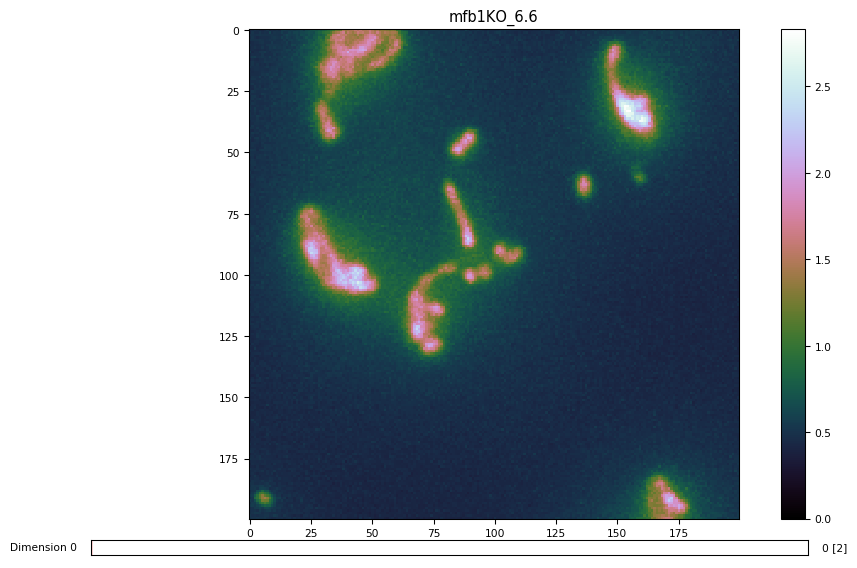

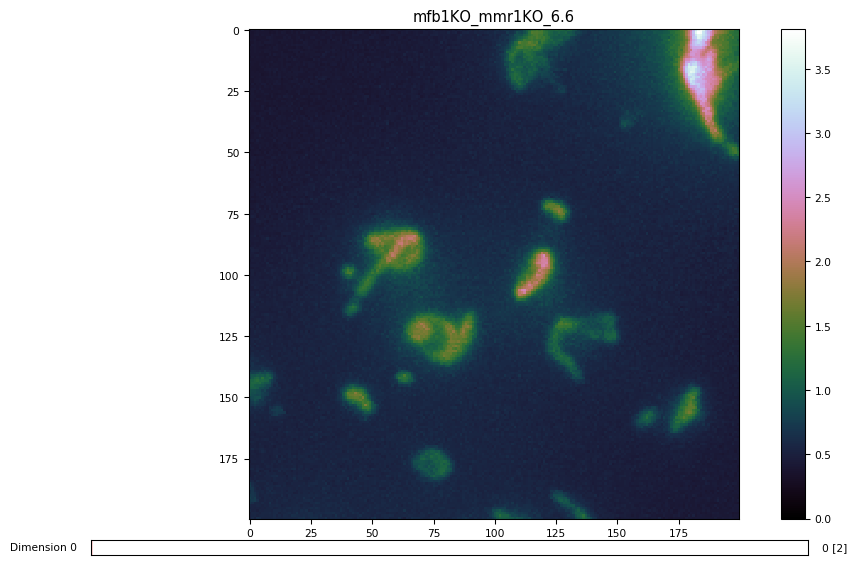

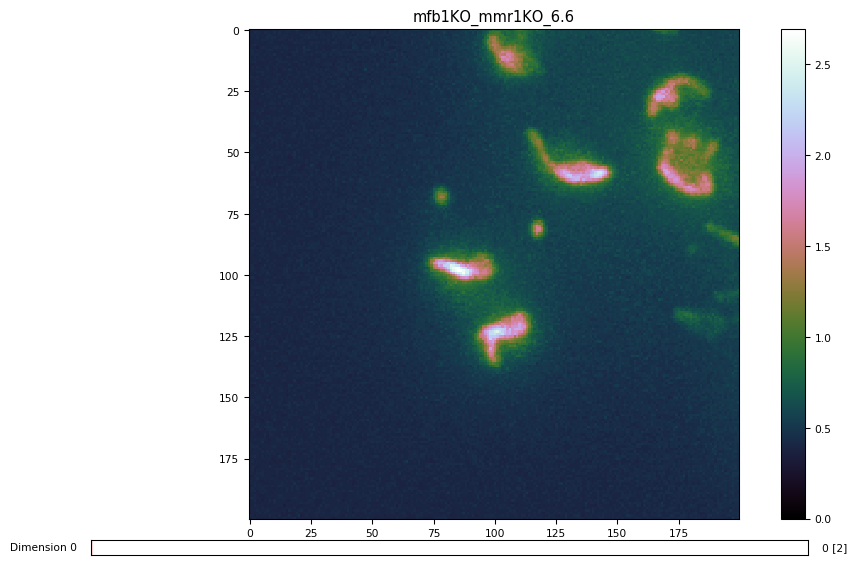

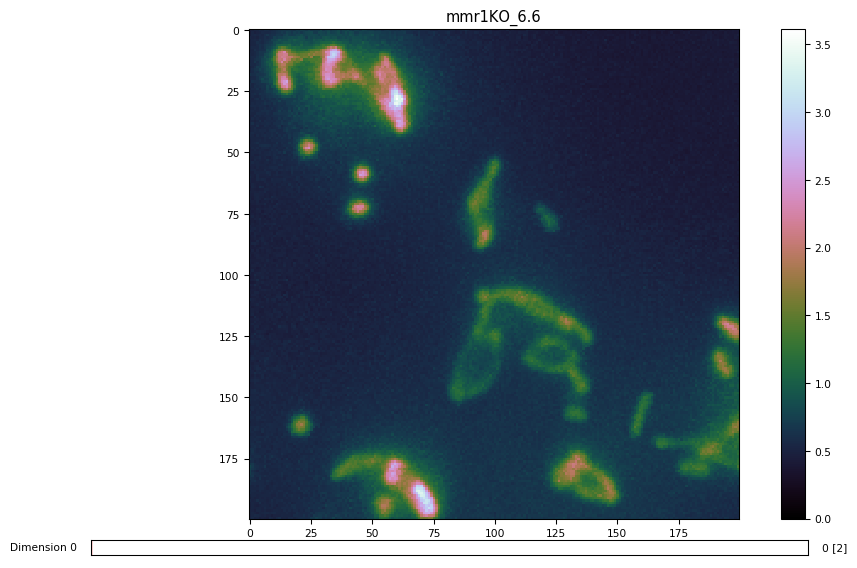

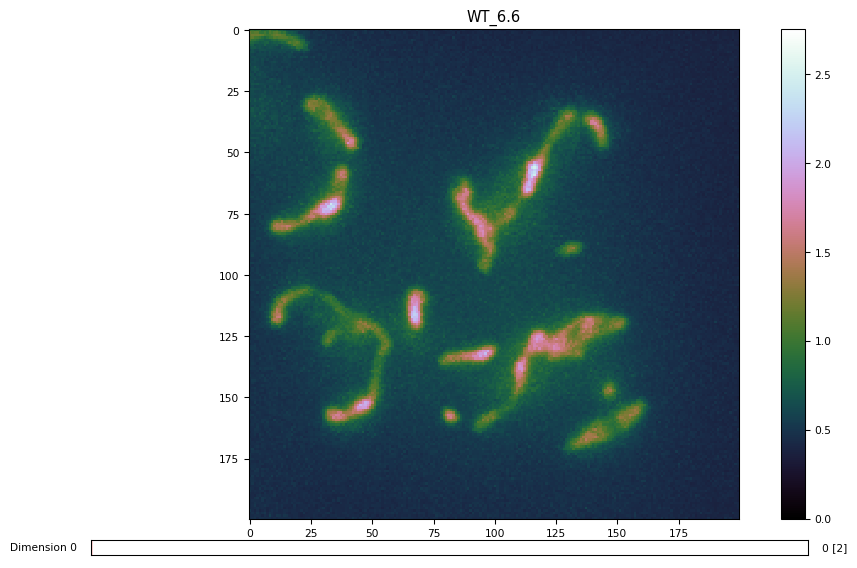

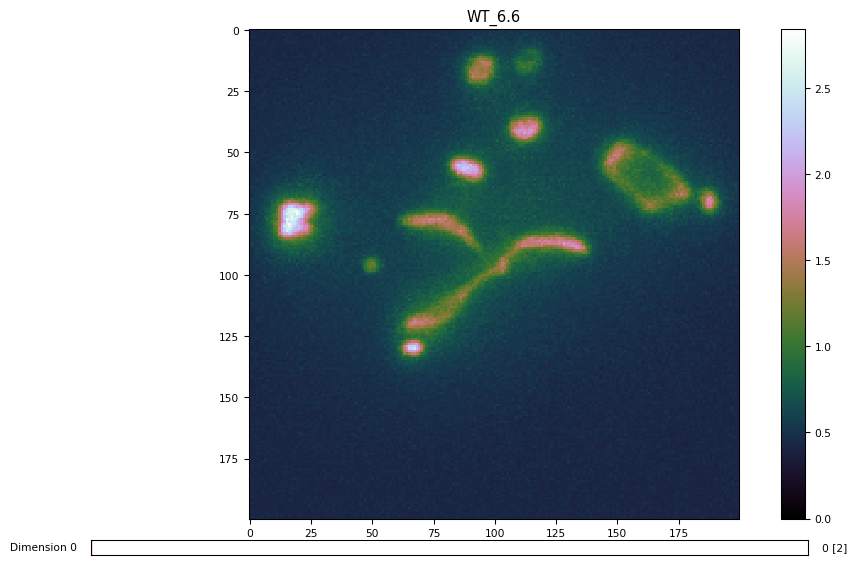

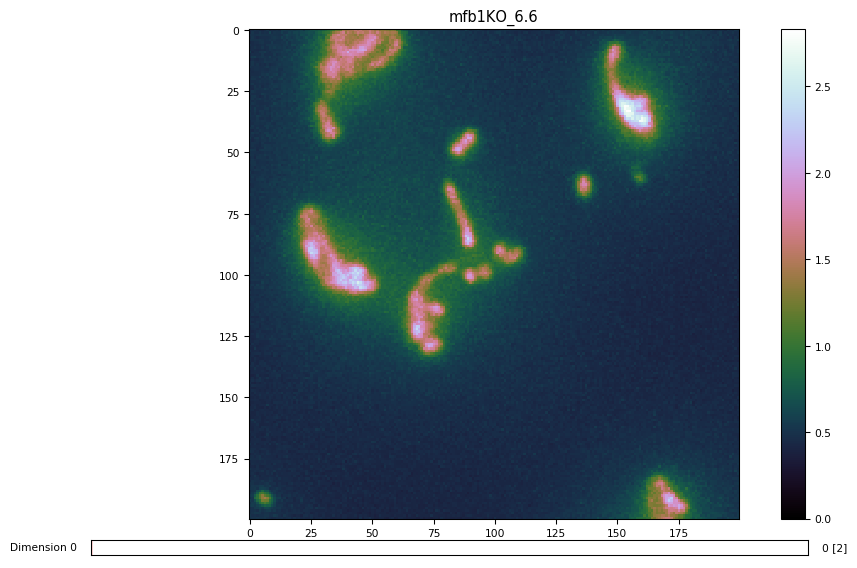

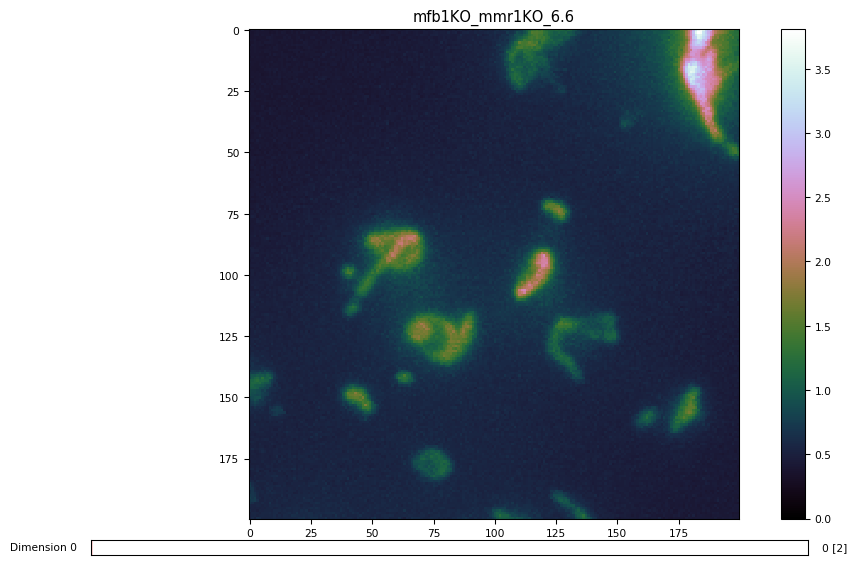

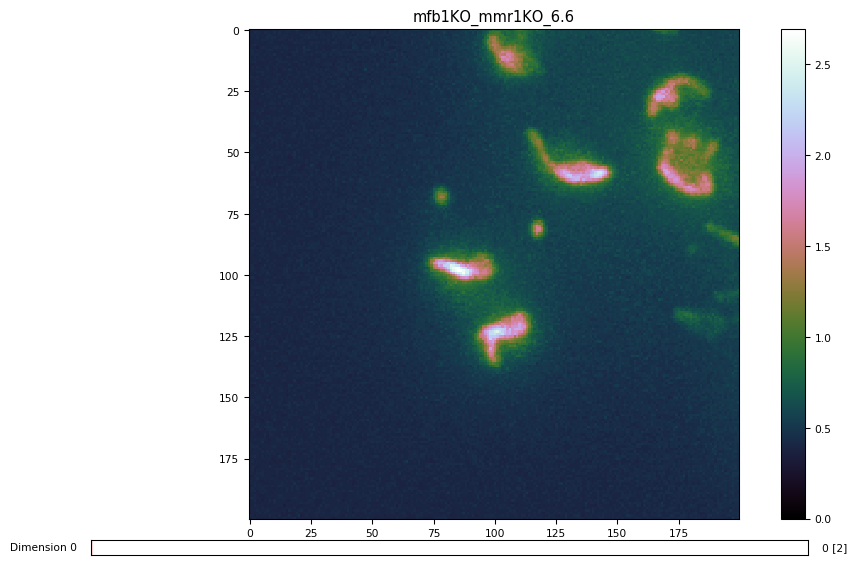

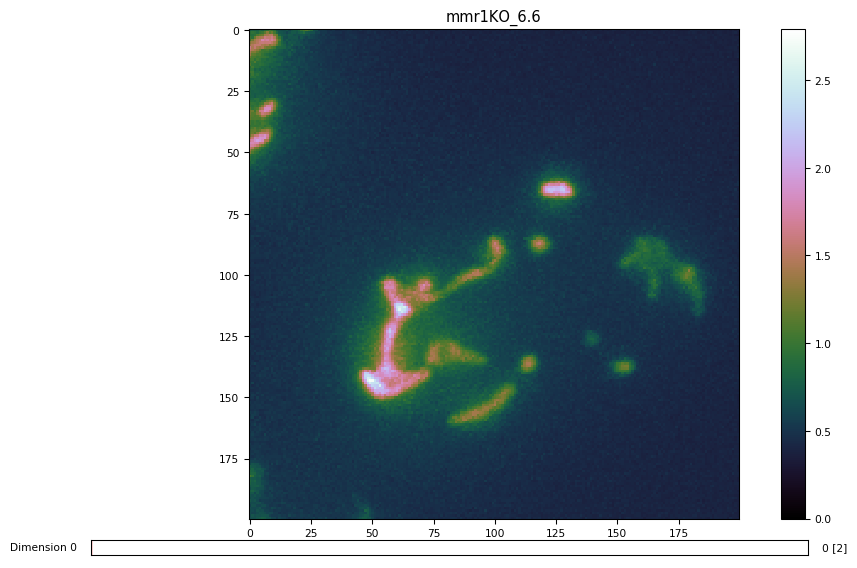

In [12]:
EPOCHS = 3
global_step = 0
NUM_CLASSES = 4
for i in range(EPOCHS):
    train(i)
    test(i)
    
print("\n Finished training.")